<a href="https://colab.research.google.com/github/akash02ita/CPSC-599.6-DL-for-Vision/blob/main/a2/DL4Vision_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
In this assignment, we will use a multi-layer perceptron network to build an image classifier for single digits. We will be using a public dataset for model development. The dataset we will be using is the MNIST digit dataset. The dataset contains 10 classes, where class `i` contains images of digit `i`.

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch.optim as optim

####1. Create train_data and test_dataset objects using the MNIST digit dataset from torchvision.datasets module. (5 points)

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='data', train = True, transform=transform, download = True)
test_dataset = datasets.MNIST(root='data', train = False, transform=transform, download = True)

####2. Use the [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) method to split the `train_data` into `train_dataset` (50000 images) and `validation_dataset` dataset (10000 images). (5 points)

In [3]:
print(len(train_data))
train_dataset, validation_dataset = random_split(train_data, [50000, 10000], generator=torch.Generator().manual_seed(42))
len(train_dataset), len(validation_dataset)

60000


(50000, 10000)

#### 3. Create dataloader objects for `train_dataset`, `validation_dataset`, and `test_dataset`. (5 points)

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = 32, shuffle = True)
type(train_dataloader), len(train_dataloader), len(train_dataloader.dataset)

(torch.utils.data.dataloader.DataLoader, 1563, 50000)

In [5]:
for images, labels in train_dataloader:
  print(type(images), type(labels))
  print(images.shape, labels.shape)
  print(images[0].numpy().shape)
  break

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([32, 1, 28, 28]) torch.Size([32])
(1, 28, 28)


#### 4. Develop an MLP model for classifying MNIST images. The developed model should have four hidden layers of 256, 128, 64, and 32 neurons. Each hidden layer should be followed with a ReLU unit and a Dropout layer (p=0.2).  (15 points)

In [6]:
def initialize_model(flattened_image_shape):
  model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(flattened_image_shape, 256, bias=True),
    nn.ReLU(),
    nn.Linear(256, 128, bias=True),
    nn.ReLU(),
    nn.Linear(128, 64, bias=True),
    nn.ReLU(),
    nn.Linear(64, 32, bias=True),
    nn.Dropout(p=0.2),
    nn.Linear(32, 10, bias=True)
  )
  return model

flattened_image_shape = 1*28*28
model = initialize_model(flattened_image_shape)

#### 5. Define the components needed for training a deep learning model. (10 points)



In [7]:
def initialize_componenets(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(device)
  model = model.to(device) # returns model on the device

  return criterion, optimizer, device, model

criterion, optimizer, device, model = initialize_componenets(model)

cuda


#### 6. Write the training loop and train the model for 100 epochs. Print the training and validation accuracy and loss for each epoch. (35 points)

In [8]:
def train_model(model, epochs, train_dataloader, validation_dataloader, criterion, optimizer):
  def run_iteration(epoch, current_data, current_dataloader):
    nonlocal criterion, optimizer
    total_loss = 0
    total = 0
    correct = 0
    for images, labels in current_dataloader:
      if current_data == "TRAIN": optimizer.zero_grad()
      # data also needs to move to same device (in this case gpu)
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      if current_data == "TRAIN": # only when using training dataloader
        loss.backward()
        optimizer.step()
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1) # preds is index of maximum found in each vector ouput \element of ouputs
      correct += (preds == labels).sum().item()
    accuracy = correct / total
    loss = total_loss / total
    print(f"{epoch} {current_data}: Accuracy = {accuracy}, Loss = {loss}")

  for epoch in range(epochs):
    model.train()
    run_iteration(epoch, "TRAIN", train_dataloader)
    model.eval()
    with torch.no_grad():
      run_iteration(epoch, "VALIDATION", validation_dataloader)

epochs = 100
train_model(model, epochs, train_dataloader, validation_dataloader, criterion, optimizer)

0 TRAIN: Accuracy = 0.80716, Loss = 0.5926162271639704
0 VALIDATION: Accuracy = 0.9407, Loss = 0.2014579526335001
1 TRAIN: Accuracy = 0.9566, Loss = 0.14808884983330964
1 VALIDATION: Accuracy = 0.9558, Loss = 0.14823470635414124
2 TRAIN: Accuracy = 0.97074, Loss = 0.10013531007662416
2 VALIDATION: Accuracy = 0.9643, Loss = 0.12012654203101993
3 TRAIN: Accuracy = 0.9778, Loss = 0.07442088909912854
3 VALIDATION: Accuracy = 0.9672, Loss = 0.1111551368644461
4 TRAIN: Accuracy = 0.98288, Loss = 0.05841919322291389
4 VALIDATION: Accuracy = 0.9731, Loss = 0.08906307067913004
5 TRAIN: Accuracy = 0.98634, Loss = 0.045182911000768655
5 VALIDATION: Accuracy = 0.972, Loss = 0.10723473203629255
6 TRAIN: Accuracy = 0.98886, Loss = 0.03712964065128006
6 VALIDATION: Accuracy = 0.9689, Loss = 0.11352579903784207
7 TRAIN: Accuracy = 0.98912, Loss = 0.03406931423296221
7 VALIDATION: Accuracy = 0.9718, Loss = 0.11592528485850198
8 TRAIN: Accuracy = 0.99106, Loss = 0.02841675144765526
8 VALIDATION: Accurac

####6. Test the model using the `test_dataset`, and report accuracy and loss. (10 points)

In [9]:
def evaluate_model(model, test_dataloader, criterion):
  model.eval()
  total_loss = 0
  total = 0
  correct = 0
  for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1) # preds is index of maximum found in each vector ouput \element of ouputs
      correct += (preds == labels).sum().item()
  accuracy = correct / total
  loss = total_loss / total
  print(f"TEST: Accuracy = {accuracy}, Loss = {loss}")

evaluate_model(model, test_dataloader, criterion)

TEST: Accuracy = 0.9836, Loss = 0.154594043181607


#### 8. We would like to see how accurate the trained model is when applied to a set of images of digits with slight differences. The image of a digit in the MNIST dataset has a black background (0 value for pixel values). This might be like writing with white chalk on a blackboard. We make slight changes in the test datasets by applying a simple change `image = 1 - image`. In other words, we invert the pixel intensity values. The resulting images resemble a digit written with a black marker on a whiteboard. Test the model using the updated test_dataset, and report your observations regarding model performance. How would you change your pipeline if you redo this experiment? (15 points)

In [10]:
new_transform = transforms.Compose([transforms.ToTensor(), lambda image : 1-image])
new_test_dataset = datasets.MNIST(root='data', train = False, transform=new_transform, download = True)
new_test_dataloader = DataLoader(new_test_dataset, batch_size = 32, shuffle = True)
evaluate_model(model, new_test_dataloader, criterion)

TEST: Accuracy = 0.0374, Loss = 19.25463305358887


**8: observations**

Observing the result above the accuracy of roughly 4% is not good, when images are inverted. The model returns accurate values only for non-inverted images.

**8: how would i change my pipeline to re-do the experiment?**

The model was not trained to handle inverted images. Therefore, image augmentation can come into a play during the training phase.
While passing always the inverted image to the training model most likely causes the model to have low accuracy the moment it is tested and evaluated with non-inverted images, occasionally augmenting or not-augmenting an image in a probabilistic manner is the idea.

Therefore, the **transform** parameter when creating `train_dataset` is a composition of function which will include an additional function. That such additional function will either return the same image or invert the image on a probability basis.

In [11]:
from random import random
transform = transforms.Compose([transforms.ToTensor(), lambda image: 1-image if random() < 0.5 else image]) # image is augmented or original half of the times each
train_data = datasets.MNIST(root='data', train = True, transform=transform, download = True)
test_dataset = datasets.MNIST(root='data', train = False, transform=transform, download = True)
train_dataset, validation_dataset = random_split(train_data, [50000, 10000], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = 32, shuffle = True)

flattened_image_shape = 1*28*28
model = initialize_model(flattened_image_shape)
criterion, optimizer, device, model = initialize_componenets(model)

print("---------------------------MODEL GOING TO BE TRAINED")
epochs = 100
train_model(model, epochs, train_dataloader, validation_dataloader, criterion, optimizer)

print("\n---------------------------MODEL GOING TO BE TESTED")
evaluate_model(model, test_dataloader, criterion) # model tests with a mixture of inverted and non-inverted images

cuda
---------------------------MODEL GOING TO BE TRAINED
0 TRAIN: Accuracy = 0.62364, Loss = 1.068015902223587
0 VALIDATION: Accuracy = 0.8539, Loss = 0.5021567486524582
1 TRAIN: Accuracy = 0.88484, Loss = 0.3769985890364647
1 VALIDATION: Accuracy = 0.9149, Loss = 0.2810741762161255
2 TRAIN: Accuracy = 0.91868, Loss = 0.2715934174633026
2 VALIDATION: Accuracy = 0.9373, Loss = 0.21770315883159638
3 TRAIN: Accuracy = 0.9306, Loss = 0.23077069819658994
3 VALIDATION: Accuracy = 0.9156, Loss = 0.27506942558884623
4 TRAIN: Accuracy = 0.9426, Loss = 0.19470610631465912
4 VALIDATION: Accuracy = 0.9509, Loss = 0.1640336818650365
5 TRAIN: Accuracy = 0.94766, Loss = 0.1748394686022401
5 VALIDATION: Accuracy = 0.9516, Loss = 0.16654187958613037
6 TRAIN: Accuracy = 0.95308, Loss = 0.15658814665049314
6 VALIDATION: Accuracy = 0.9447, Loss = 0.18595723851025103
7 TRAIN: Accuracy = 0.9574, Loss = 0.1412118921779096
7 VALIDATION: Accuracy = 0.9578, Loss = 0.1406219499349594
8 TRAIN: Accuracy = 0.95942

In [12]:
print("testing model WITHOUT inverting images")
new_transform = transforms.Compose([transforms.ToTensor()]) # ALL images are NOT inverted
new_test_dataset = datasets.MNIST(root='data', train = False, transform=new_transform, download = True)
new_test_dataloader = DataLoader(new_test_dataset, batch_size = 32, shuffle = True)
evaluate_model(model, new_test_dataloader, criterion)

print()

print("testing model WITH inverted images")
new_transform = transforms.Compose([transforms.ToTensor(), lambda image : 1-image]) # ALL images will be inverted
new_test_dataset = datasets.MNIST(root='data', train = False, transform=new_transform, download = True)
new_test_dataloader = DataLoader(new_test_dataset, batch_size = 32, shuffle = True)
evaluate_model(model, new_test_dataloader, criterion)

testing model WITHOUT inverting images
TEST: Accuracy = 0.9782, Loss = 0.14206674390419421

testing model WITH inverted images
TEST: Accuracy = 0.9715, Loss = 0.14059012982236307


As shown above, the model accuracy now is satisfiable both for **inverted images** and **non-inverted images**.

## Visually test model

In [13]:
import matplotlib.pyplot as plt
import math
def visualize(image_and_label, transform=lambda image : image):
  image, label = image_and_label
  image = transform(image)
  plt.figure()
  plt.imshow(image)
  plt.title(str(label))
def visualize_multi(images_and_labels, cols=5, transform=lambda image : image):
  tot = len(images_and_labels)
  if tot == 1:
    visualize(images_and_labels[0], transform)

  assert isinstance(cols,int) and cols > 0
  rows = math.ceil(tot/cols)

  fig = plt.figure(figsize=(20,20))

  for i in range(tot):
      image, label = images_and_labels[i]
      image = transform(image)
      fig.add_subplot(rows, cols, i+1)
      plt.imshow(image)
      plt.title(str(label))

  fig.tight_layout(pad=5.0)

  plt.show()

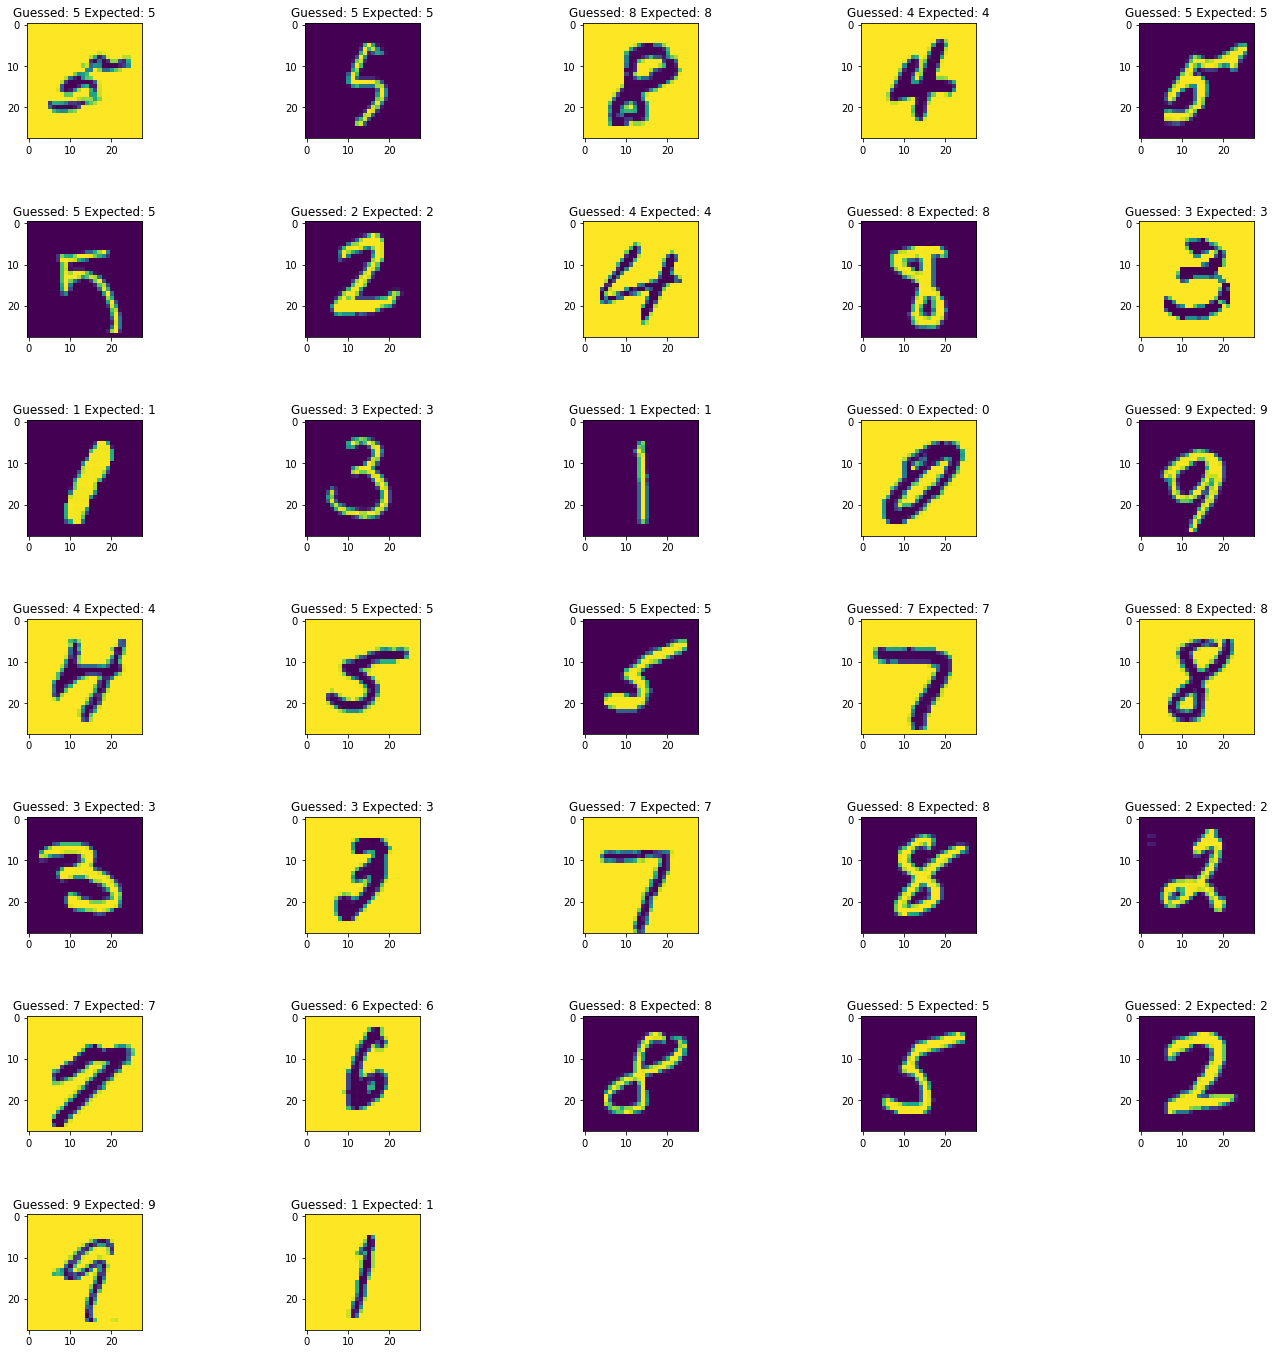

In [14]:
images, labels = next(iter(train_dataloader))


transform_image = lambda image : image.flatten(0,1) # (1,28,28) -> (28,28) shape

model.eval()
images, labels = images.to(device), labels.to(device)
outputs = model(images)
outputs = torch.max(outputs, 1)[1] # select the output node with highest value
plot_labels = [f"Guessed: {guess} Expected: {expect}" for guess, expect in zip(outputs, labels)]

cpu_device = torch.device("cpu")
images = images.to(cpu_device)

visualize_multi(list(zip(images, plot_labels)), transform=transform_image)

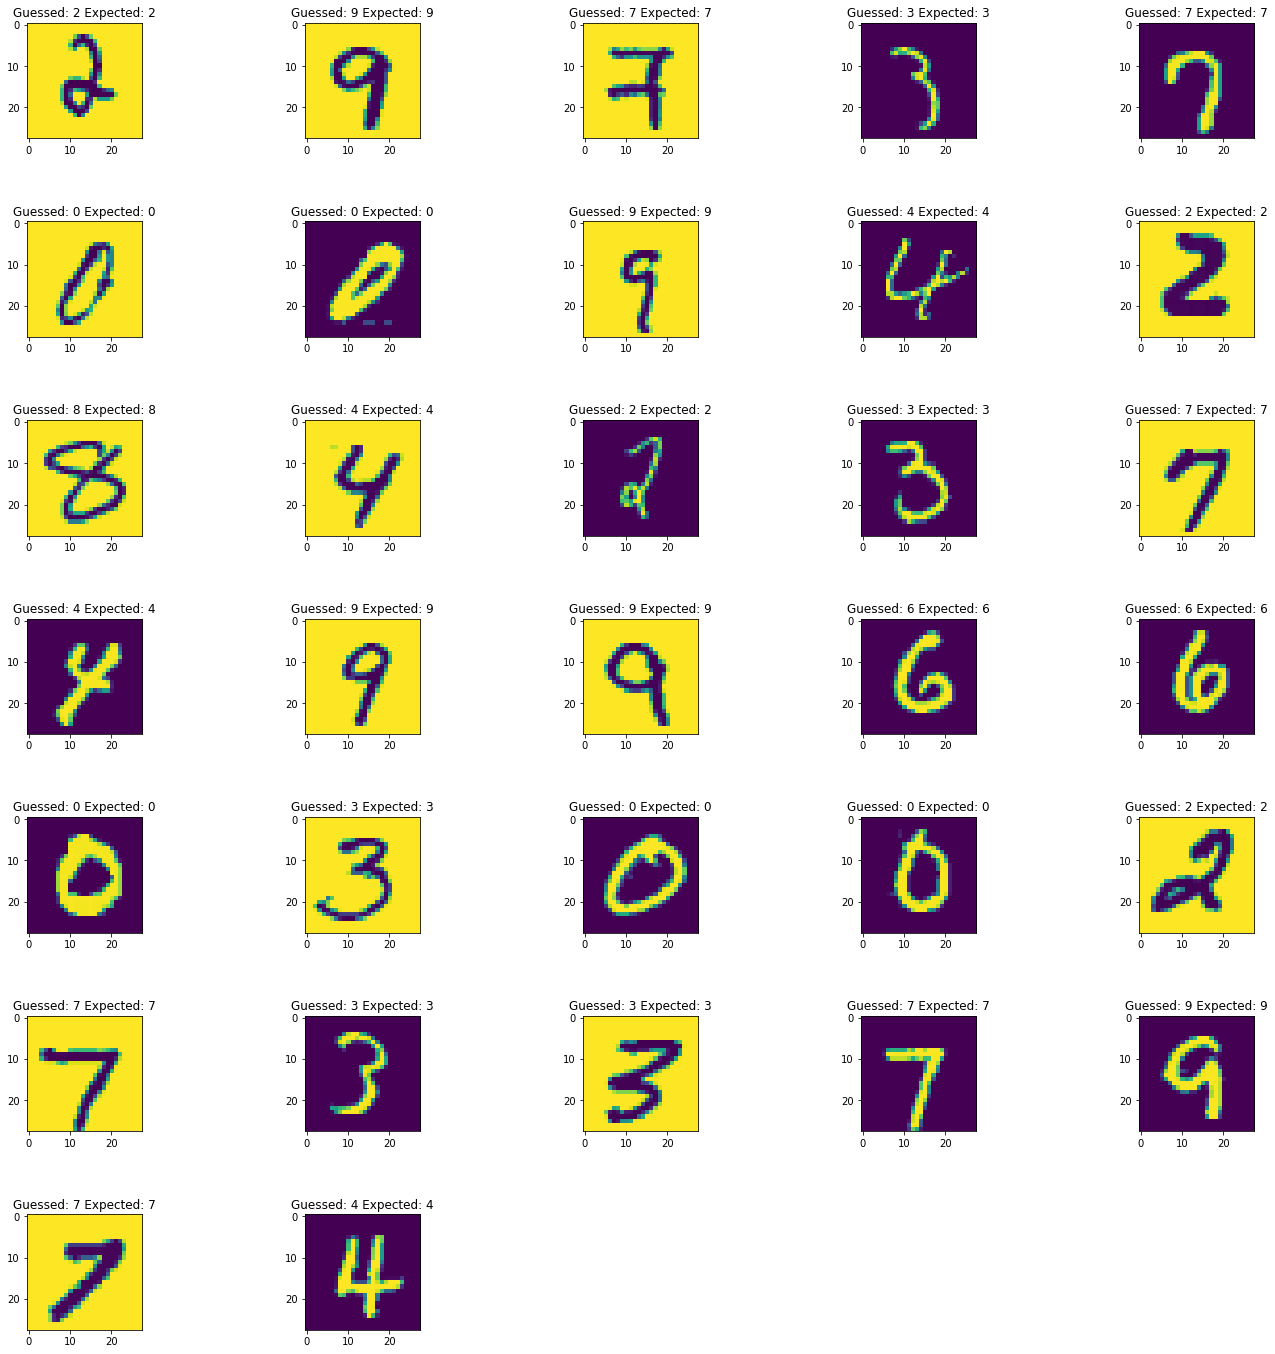

In [15]:
images, labels = next(iter(validation_dataloader))


transform_image = lambda image : image.flatten(0,1) # (1,28,28) -> (28,28) shape

model.eval()
images, labels = images.to(device), labels.to(device)
outputs = model(images)
outputs = torch.max(outputs, 1)[1]
plot_labels = [f"Guessed: {guess} Expected: {expect}" for guess, expect in zip(outputs, labels)]

cpu_device = torch.device("cpu")
images = images.to(cpu_device)

visualize_multi(list(zip(images, plot_labels)), transform=transform_image)

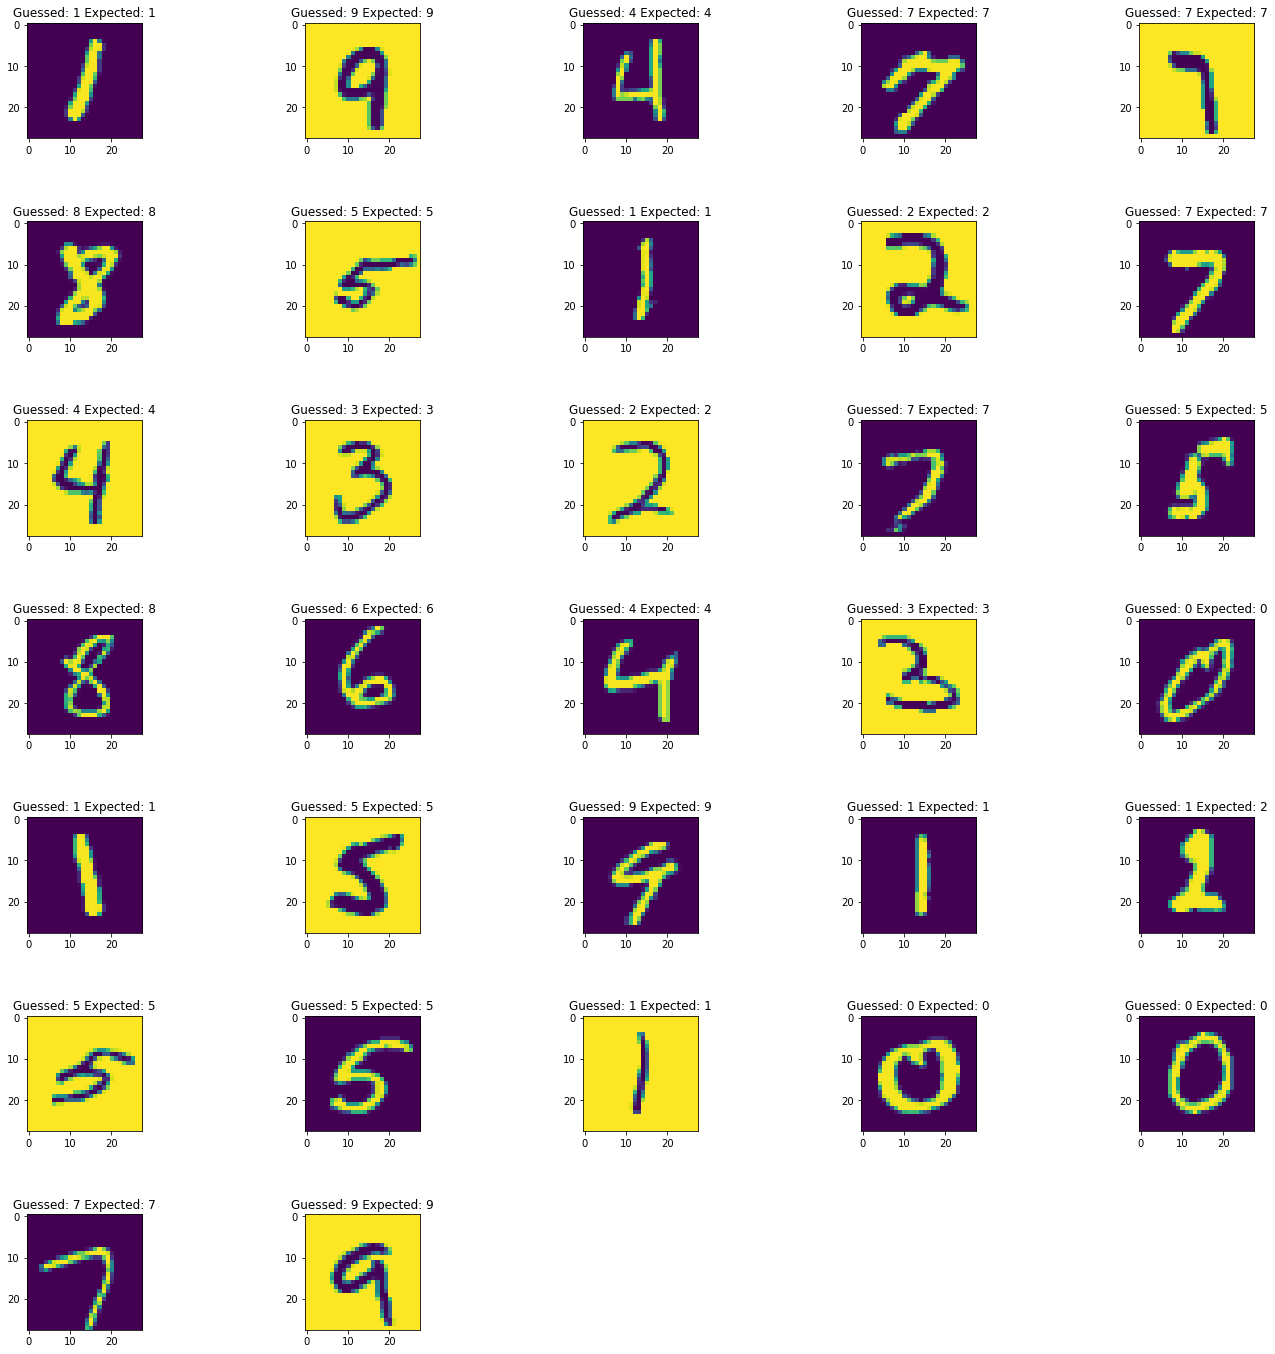

In [16]:
images, labels = next(iter(test_dataloader))


transform_image = lambda image : image.flatten(0,1) # (1,28,28) -> (28,28) shape

model.eval()
images, labels = images.to(device), labels.to(device)
outputs = model(images)
outputs = torch.max(outputs, 1)[1]
plot_labels = [f"Guessed: {guess} Expected: {expect}" for guess, expect in zip(outputs, labels)]

cpu_device = torch.device("cpu")
images = images.to(cpu_device)

visualize_multi(list(zip(images, plot_labels)), transform=transform_image)